# **Installing & Importing Libraries**

In [1]:
!pip install netCDF4 xarray numpy pandas matplotlib tensorflow pmdarima streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00


In [2]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import streamlit as st
from pyngrok import ngrok
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("all libraries imported successfully!")

all libraries imported successfully!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Loading & Exploration**

In [ ]:
# Open NetCDF file
path = r"/content/drive/MyDrive/Python Project/IMDAA_1990_2020.nc"

try:
    ds = xr.open_dataset(path)  # Try default engine first
except OSError:
    print("⚠️ netCDF4 failed — retrying with h5netcdf engine...")
    ds = xr.open_dataset(path, engine="h5netcdf")

print("✅ Dataset loaded successfully!")


⚠️ netCDF4 failed — retrying with h5netcdf engine...
✅ Dataset loaded successfully!


In [ ]:
geoPotentialHt_pressureLvl = ds['HGT_prl']
geoPotentialHt_pressureLvl

<xarray.DataArray 'HGT_prl' (time: 45292, latitude: 32, longitude: 32)> Size: 186MB
[46379008 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat      (latitude) float64 256B ...
    lon      (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Attributes:
    long_name:   Geopotential Height
    units:       m
    short_name:  HGT
    level:       pressure level

In [ ]:
temp_pressureLvl = ds['TMP_prl']
temp_pressureLvl

<xarray.DataArray 'TMP_prl' (time: 45292, latitude: 32, longitude: 32)> Size: 186MB
[46379008 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat      (latitude) float64 256B ...
    lon      (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Attributes:
    long_name:   Temperature
    units:       K
    short_name:  TMP
    level:       pressure level

In [ ]:
temp_2m = ds['TMP_2m']
temp_2m

<xarray.DataArray 'TMP_2m' (time: 45292, latitude: 32, longitude: 32)> Size: 186MB
[46379008 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat      (latitude) float64 256B ...
    lon      (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Attributes:
    long_name:   Temperature
    units:       K
    short_name:  TMP_2maboveground
    level:       2 m above ground

In [ ]:
precipitation = ds['APCP_sfc']
precipitation

<xarray.DataArray 'APCP_sfc' (time: 45292, latitude: 32, longitude: 32)> Size: 186MB
[46379008 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat      (latitude) float64 256B ...
    lon      (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Attributes:
    long_name:   Total Precipitation
    units:       kg/m^2
    short_name:  APCP_surface
    level:       surface

In [ ]:
print(ds.dims)       # shows dimension names
print(ds.coords)     # shows coordinate variables

FrozenMappingWarningOnValuesAccess({'time': 45292, 'latitude': 32, 'longitude': 32})
Coordinates:
  * time     (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat      (latitude) float64 256B ...
    lon      (longitude) float64 256B ...


In [ ]:
print(ds['lat'].values.min(), ds['lat'].values.max())
print(ds['lon'].values.min(), ds['lon'].values.max())

5.04 38.52
65.04 98.51999999999995


In [ ]:
lat_idx = np.abs(ds['lat'].values - 28.6).argmin()
lon_idx = np.abs(ds['lon'].values - 77.2).argmin()

print("Nearest grid cell:",
      ds['lat'].values[lat_idx],
      ds['lon'].values[lon_idx])

# Extract the whole time series at that grid
point = temp_pressureLvl.isel(latitude=lat_idx, longitude=lon_idx)
print(point.values[:20])   # first 20 values

Nearest grid cell: 28.8 76.91999999999999
[282.58948 281.498   282.22665 281.6416  281.23578 280.7401  280.9886
 281.58347 280.99933 281.6792  281.76736 282.3791  282.68164 281.81284
 281.74673 282.71378 282.51733 282.3816  282.92862 282.9722 ]


In [ ]:
timeseries = point.to_pandas()
timeseries.head()

,TMP_prl
time,
1990-01-01 00:00:00,282.589478
1990-01-01 06:00:00,281.497986
1990-01-01 12:00:00,282.226654
1990-01-01 18:00:00,281.641602
1990-01-02 00:00:00,281.235779


In [ ]:
timeseries_c = timeseries - 273.15  # converting to celsius

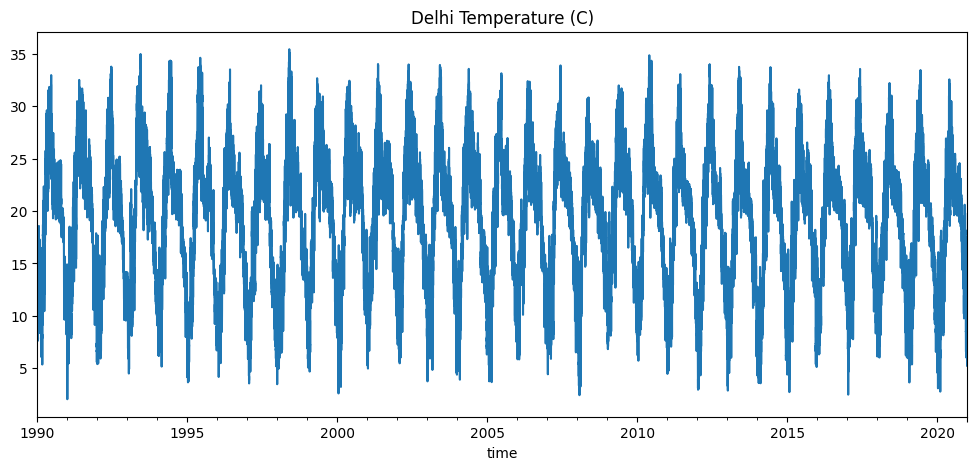

In [ ]:
timeseries_c.plot(figsize=(12,5), title="Delhi Temperature (C)")
plt.show()

In [ ]:
ds.data_vars

Data variables:
    HGT_prl   (time, latitude, longitude) float32 186MB ...
    TMP_prl   (time, latitude, longitude) float32 186MB ...
    TMP_2m    (time, latitude, longitude) float32 186MB ...
    APCP_sfc  (time, latitude, longitude) float32 186MB ...

# **Predicting Values**

In [ ]:
def extract_timeseries(ds, var, lat, lon, city_name="Location"):
    lat_idx = np.abs(ds['lat'].values - lat).argmin()
    lon_idx = np.abs(ds['lon'].values - lon).argmin()

    nearest_lat = ds['lat'].values[lat_idx]
    nearest_lon = ds['lon'].values[lon_idx]

    print(f"Nearest grid cell for {city_name}: {nearest_lat:.2f}, {nearest_lon:.2f}")

    point = ds[var].isel(latitude=lat_idx, longitude=lon_idx)
    ts = point.to_pandas()

    # Convert from Kelvin → Celsius (since better interpretability)
    if "units" in ds[var].attrs and ds[var].attrs["units"] in ["K", "kelvin", "Kelvin"]:
        ts = ts - 273.15
        ts.name = f"{var}_Celsius"
    else:
        ts.name = var

    # Plot
    ts.plot(figsize=(12,5), title=f"{city_name} {var} Time Series")
    plt.show()

    return ts

In [ ]:
coords = {
        "delhi": (28.6, 77.2),
        "vellore": (12.9, 79.1),
        "mumbai": (19.1, 72.8),
        "chennai": (13.1, 80.3),
    }

In [ ]:
var_descriptions = {
    "HGT_prl":  "Geopotential Height (Pressure Level) – Used to analyze large-scale weather patterns",
    "TMP_prl":  "Temperature (Pressure Level) – Atmospheric temperature at a specific pressure level",
    "TMP_2m":   "Surface Air Temperature at 2 meters – What we feel as daily temperature",
    "APCP_sfc": "Total Precipitation – Rainfall or snowfall accumulated over time",
}

# **ARIMA (AutoRegressive Integrated Moving Average)**

In [ ]:
def run_arima():
    city = input("Enter city name (or 'exit' to quit): ")
    if city.lower() == "exit":
        return False  # stop running

    # --- Latitude / Longitude Selection ---
    if city.lower() in coords:
        lat, lon = coords[city.lower()]
    else:
        print("City not in list. Please enter lat/lon manually.")
        try:
            lat = float(input("Enter latitude: "))
            lon = float(input("Enter longitude: "))
            coords[city.lower()] = (lat, lon)
        except:
            print("⚠️ Invalid lat/lon input.")
            return

    # --- Variable Selection ---
    print("\n📊 Available Data Variables:")
    for var in ds.data_vars:
        desc = var_descriptions.get(var, "No description available.")
        print(f"  • {var} → {desc}")
    var_name = input("Choose data variable: ")
    if (var_name not in list(ds.data_vars)):
        print("⚠️ Invalid input. No data variable matches your input, exiting...")
        return

    print(f"\n✅ Extracting {var_name} ({var_descriptions.get(var_name,'')}) for {city.title()}...")
    ts = extract_timeseries(ds, var_name, lat, lon, city_name=city.title())

    # --- Rolling Mean & Anomaly ---
    print("📊 Computing 365-day rolling mean & anomalies...")
    ts_rolling = ts.rolling(365, center=True).mean()
    anomaly = ts - ts_rolling

    # Plot anomalies
    print("📈 Plotting anomalies...")
    anomaly.plot(title=f"{city.title()} {var_name} Anomalies")
    plt.xlabel("Time")
    plt.ylabel(f"{var_name} (Anomaly)")
    plt.show()

    # --- Clean data for ARIMA ---
    print("🧹 Cleaning data (dropping NaNs) for ARIMA model...")
    series = ts.dropna()

    # --- MODEL EVALUATION ---
    print("🧪 Splitting data into train/test for evaluation...")
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    print("🤖 Fitting ARIMA(5,1,0) model on training data...")
    model = ARIMA(train, order=(5, 1, 0))
    fit = model.fit()

    print("🔍 Generating predictions on test data...")
    preds = fit.forecast(steps=len(test))

    # Metrics
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    smape = 100 * np.mean(2 * np.abs(test - preds) / (np.abs(test) + np.abs(preds) + 1e-8))

    # Plot train/test predictions
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test", color="green")
    plt.plot(test.index, preds, label="Predicted", color="orange")
    plt.legend()
    plt.title(f"{city.title()} {var_name} - Model Evaluation")
    plt.show()

    # --- Forecast Horizon ---
    try:
        steps = int(input("Enter forecast horizon (number of days): "))
    except:
        print("⚠️ Invalid input. Using default 365 days.")
        steps = 365

    # --- FINAL FORECAST ---
    print(f"\n🔮 Forecasting next {steps} days on FULL dataset...")
    final_model = ARIMA(series, order=(5, 1, 0))
    final_fit = final_model.fit()
    forecast = final_fit.forecast(steps=steps)

    trend_forecast = "increasing" if forecast.iloc[-1] > series.iloc[-1] else "decreasing"
    print(f"- Expected trend: {trend_forecast}")

    # Plot observed vs forecast
    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series, label="Observed")
    plt.plot(forecast.index, forecast, label=f"Forecast ({steps} days)", color='red')
    plt.legend()
    plt.title(f"{city.title()} {var_name} - Observed vs Forecast")
    plt.xlabel("Time")
    plt.ylabel(var_name)
    plt.show()

    # --- Historical Summary for Stakeholders ---
    print("\n📌 Stakeholder-Friendly Summary:")
    mean_val = ts.mean()
    max_val = ts.max()
    min_val = ts.min()
    trend = "increasing" if ts.iloc[-1] > ts.iloc[0] else "decreasing"
    high_anomaly_days = (anomaly > anomaly.std()).sum()
    low_anomaly_days = (anomaly < -anomaly.std()).sum()

    print(f"- Historical period: {ts.index.min().date()} to {ts.index.max().date()}")
    print(f"- Average {var_name}: {mean_val:.2f}")
    print(f"- Maximum {var_name}: {max_val:.2f}")
    print(f"- Minimum {var_name}: {min_val:.2f}")
    print(f"- Overall trend: {trend}")
    print(f"- Days with unusually high {var_name}: {high_anomaly_days}")
    print(f"- Days with unusually low {var_name}: {low_anomaly_days}")

    print("\n📊 Model Evaluation Metrics (last 20% of data):")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"SMAPE: {smape:.2f}%")

    # --- Stakeholder-Friendly Forecast Summary ---
    forecast_mean = forecast.mean()
    forecast_max = forecast.max()
    forecast_min = forecast.min()
    print("\n📋 Forecast Summary:")
    print(f"- Forecast period: {forecast.index.min().date()} to {forecast.index.max().date()}")
    print(f"- Expected average {var_name}: {forecast_mean:.2f}")
    print(f"- Expected maximum {var_name}: {forecast_max:.2f}")
    print(f"- Expected minimum {var_name}: {forecast_min:.2f}")

    print("\n✅ Analysis complete!\n")
    print("\n💡 Insights:")
    if trend_forecast == "increasing":
        print(f"- Next {steps} days are expected to show a slight increase in {var_name} compared to historical averages.")
    else:
        print(f"- Next {steps} days are expected to show a slight decrease in {var_name} compared to historical averages.")

    if high_anomaly_days > low_anomaly_days:
        print(f"- Historically, {city.title()} has experienced more unusually high {var_name} days than low.")
    elif low_anomaly_days > high_anomaly_days:
        print(f"- Historically, {city.title()} has experienced more unusually low {var_name} days than high.")
    else:
        print(f"- Historically, {city.title()} has balanced occurrences of high and low {var_name} days.")

    print("\nNote: Forecasted values include minor uncertainty.")

    return


Enter city name (or 'exit' to quit): vellore

📊 Available Data Variables:
  • HGT_prl → Geopotential Height (Pressure Level) – Used to analyze large-scale weather patterns
  • TMP_prl → Temperature (Pressure Level) – Atmospheric temperature at a specific pressure level
  • TMP_2m → Surface Air Temperature at 2 meters – What we feel as daily temperature
  • APCP_sfc → Total Precipitation – Rainfall or snowfall accumulated over time
Choose data variable: HGT_prl

✅ Extracting HGT_prl (Geopotential Height (Pressure Level) – Used to analyze large-scale weather patterns) for Vellore...
Nearest grid cell for Vellore: 12.60, 79.08


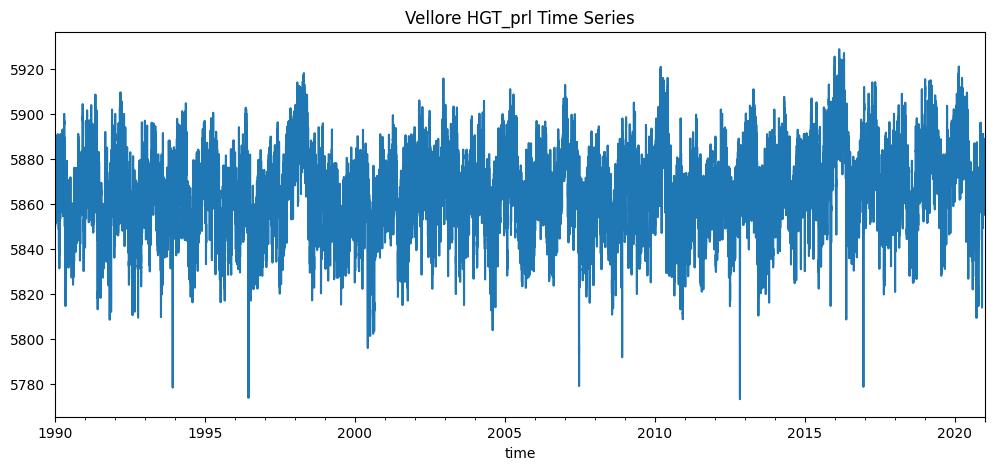

📊 Computing 365-day rolling mean & anomalies...
📈 Plotting anomalies...


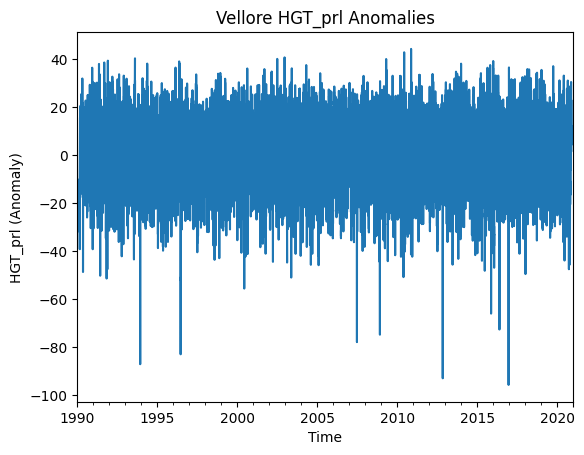

🧹 Cleaning data (dropping NaNs) for ARIMA model...
🧪 Splitting data into train/test for evaluation...
🤖 Fitting ARIMA(5,1,0) model on training data...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)


🔍 Generating predictions on test data...


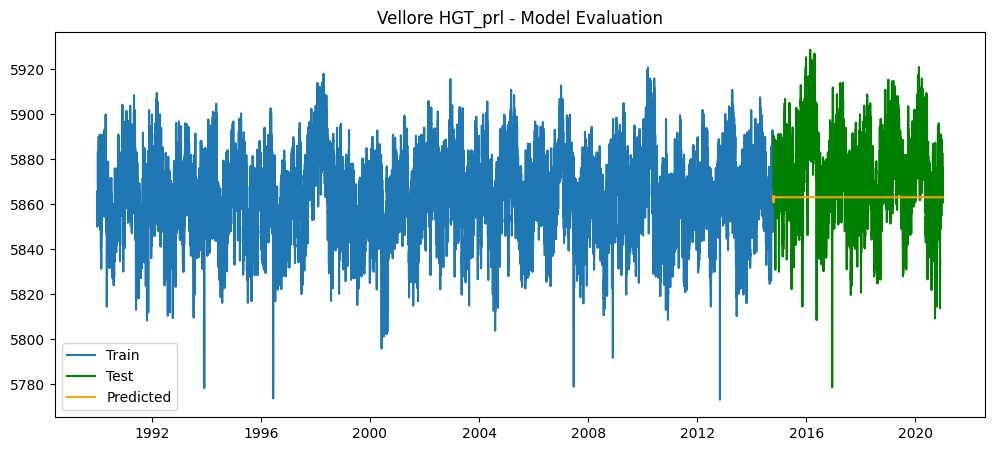

Enter forecast horizon (number of days): 10

🔮 Forecasting next 10 days on FULL dataset...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 6h will be used.
  self._init_dates(dates, freq)


- Expected trend: decreasing


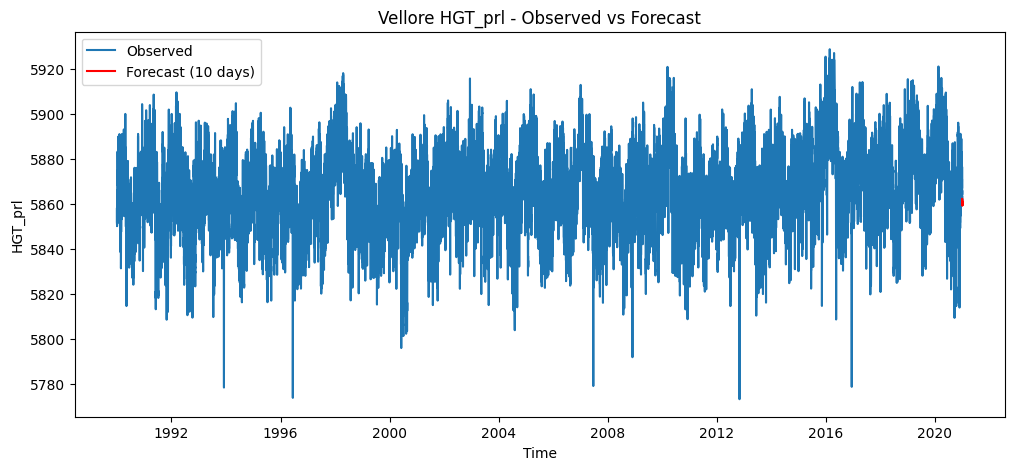


📌 Stakeholder-Friendly Summary:
- Historical period: 1990-01-01 to 2020-12-31
- Average HGT_prl: 5865.05
- Maximum HGT_prl: 5928.75
- Minimum HGT_prl: 5773.03
- Overall trend: increasing
- Days with unusually high HGT_prl: 6948
- Days with unusually low HGT_prl: 6999

📊 Model Evaluation Metrics (last 20% of data):
MAE  : 16.531
RMSE : 20.352
SMAPE: 0.28%

📋 Forecast Summary:
- Forecast period: 2021-01-01 to 2021-01-03
- Expected average HGT_prl: 5860.37
- Expected maximum HGT_prl: 5862.25
- Expected minimum HGT_prl: 5859.22

✅ Analysis complete!


💡 Insights:
- Next 10 days are expected to show a slight decrease in HGT_prl compared to historical averages.
- Historically, Vellore has experienced more unusually low HGT_prl days than high.

Note: Forecasted values include minor uncertainty.


In [ ]:
run_arima()

# **LSTM (Long Short-Term Memory)**

In [ ]:
def run_lstm():
    city = input("Enter city name (or 'exit' to quit): ")
    if city.lower() == "exit":
        return False  # stop running

    # --- Latitude / Longitude Selection ---
    if city.lower() in coords:
        lat, lon = coords[city.lower()]
    else:
        print("City not in list. Please enter lat/lon manually.")
        try:
            lat = float(input("Enter latitude: "))
            lon = float(input("Enter longitude: "))
            coords[city.lower()] = (lat, lon)
        except:
            print("⚠️ Invalid lat/lon input.")
            return

    # --- Variable Selection ---
    print("\n📊 Available Data Variables:")
    for var in ds.data_vars:
        desc = var_descriptions.get(var, "No description available.")
        print(f"  • {var} → {desc}")
    var_name = input("Choose data variable: ")
    if (var_name not in list(ds.data_vars)):
        print("⚠️ Invalid input. No data variable matches your input, exiting...")
        return

    print(f"\n✅ Extracting {var_name} ({var_descriptions.get(var_name,'')}) for {city.title()}...")
    ts = extract_timeseries(ds, var_name, lat, lon, city_name=city.title())

    # --- Rolling Mean & Anomaly ---
    print("📊 Computing 365-day rolling mean & anomalies...")
    ts_rolling = ts.rolling(365, center=True).mean()
    anomaly = ts - ts_rolling

    # Plot anomalies
    print("📈 Plotting anomalies...")
    anomaly.plot(title=f"{city.title()} {var_name} Anomalies")
    plt.xlabel("Time")
    plt.ylabel(f"{var_name} (Anomaly)")
    plt.show()

    # --- Clean data for LSTM ---
    print("🧹 Cleaning data (dropping NaNs) for LSTM model...")
    series = ts.dropna()
    data = series.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # --- Prepare sequences ---
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 30  # number of past days to use for prediction
    X, y = create_sequences(scaled_data, seq_length)

    # Split into train/test
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # --- Build LSTM Model ---
    print("🤖 Building LSTM model...")
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # --- Train with progress bar ---
    print("🧪 Training LSTM model...")
    epochs = 20
    for epoch in tqdm(range(epochs), desc="Training epochs"):
        model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)

    # --- Predictions ---
    print("🔍 Generating predictions on test data...")
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    y_test_inv = scaler.inverse_transform(y_test)

    # Metrics
    mae = mean_absolute_error(y_test_inv, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
    smape = 100 * np.mean(2 * np.abs(y_test_inv - y_pred) / (np.abs(y_test_inv) + np.abs(y_pred) + 1e-8))

    # Plot train/test predictions
    plt.figure(figsize=(12, 5))
    plt.plot(series.index[:train_size + seq_length], series.values[:train_size + seq_length], label="Train")
    plt.plot(series.index[train_size + seq_length:], y_test_inv, label="Test", color="green")
    plt.plot(series.index[train_size + seq_length:], y_pred, label="Predicted", color="orange")
    plt.legend()
    plt.title(f"{city.title()} {var_name} - Model Evaluation")
    plt.show()

    # --- Forecast Horizon ---
    try:
        steps = int(input("Enter forecast horizon (number of days): "))
    except:
        print("⚠️ Invalid input. Using default 30 days.")
        steps = 30

    # --- Final Forecast ---
    print(f"\n🔮 Forecasting next {steps} days on FULL dataset...")
    full_X, _ = create_sequences(scaled_data, seq_length)
    last_seq = scaled_data[-seq_length:]
    forecast_scaled = []

    for _ in tqdm(range(steps), desc="Forecasting"):
        pred = model.predict(last_seq.reshape(1, seq_length, 1))
        forecast_scaled.append(pred[0,0])
        last_seq = np.append(last_seq[1:], pred[0,0])

    forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1,1))
    forecast_index = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=steps)
    forecast_series = pd.Series(forecast.flatten(), index=forecast_index)

    trend_forecast = "increasing" if forecast_series.iloc[-1] > series.iloc[-1] else "decreasing"
    print(f"- Expected trend: {trend_forecast}")

    # Plot observed vs forecast
    plt.figure(figsize=(12,5))
    plt.plot(series.index, series, label="Observed")
    plt.plot(forecast_series.index, forecast_series, label=f"Forecast ({steps} days)", color='red')
    plt.legend()
    plt.title(f"{city.title()} {var_name} - Observed vs Forecast")
    plt.xlabel("Time")
    plt.ylabel(var_name)
    plt.show()

    # --- Historical Summary for Stakeholders ---
    print("\n📌 Stakeholder-Friendly Summary:")
    mean_val = ts.mean()
    max_val = ts.max()
    min_val = ts.min()
    trend = "increasing" if ts.iloc[-1] > ts.iloc[0] else "decreasing"
    high_anomaly_days = (anomaly > anomaly.std()).sum()
    low_anomaly_days = (anomaly < -anomaly.std()).sum()

    print(f"- Historical period: {ts.index.min().date()} to {ts.index.max().date()}")
    print(f"- Average {var_name}: {mean_val:.2f}")
    print(f"- Maximum {var_name}: {max_val:.2f}")
    print(f"- Minimum {var_name}: {min_val:.2f}")
    print(f"- Overall trend: {trend}")
    print(f"- Days with unusually high {var_name}: {high_anomaly_days}")
    print(f"- Days with unusually low {var_name}: {low_anomaly_days}")

    print("\n📊 Model Evaluation Metrics (last 20% of data):")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"SMAPE: {smape:.2f}%")

    # --- Stakeholder-Friendly Forecast Summary ---
    forecast_mean = forecast_series.mean()
    forecast_max = forecast_series.max()
    forecast_min = forecast_series.min()
    print("\n📋 Forecast Summary:")
    print(f"- Forecast period: {forecast_series.index.min().date()} to {forecast_series.index.max().date()}")
    print(f"- Expected average {var_name}: {forecast_mean:.2f}")
    print(f"- Expected maximum {var_name}: {forecast_max:.2f}")
    print(f"- Expected minimum {var_name}: {forecast_min:.2f}")

    print("\n✅ Analysis complete!\n")
    print("\n💡 Insights:")
    if trend_forecast == "increasing":
        print(f"- Next {steps} days are expected to show a slight increase in {var_name} compared to historical averages.")
    else:
        print(f"- Next {steps} days are expected to show a slight decrease in {var_name} compared to historical averages.")

    if high_anomaly_days > low_anomaly_days:
        print(f"- Historically, {city.title()} has experienced more unusually high {var_name} days than low.")
    elif low_anomaly_days > high_anomaly_days:
        print(f"- Historically, {city.title()} has experienced more unusually low {var_name} days than high.")
    else:
        print(f"- Historically, {city.title()} has balanced occurrences of high and low {var_name} days.")

    print("\nNote: Forecasted values include minor uncertainty.")

    return

Enter city name (or 'exit' to quit): vellore

📊 Available Data Variables:
  • HGT_prl → Geopotential Height (Pressure Level) – Used to analyze large-scale weather patterns
  • TMP_prl → Temperature (Pressure Level) – Atmospheric temperature at a specific pressure level
  • TMP_2m → Surface Air Temperature at 2 meters – What we feel as daily temperature
  • APCP_sfc → Total Precipitation – Rainfall or snowfall accumulated over time
Choose data variable: HGT_prl

✅ Extracting HGT_prl (Geopotential Height (Pressure Level) – Used to analyze large-scale weather patterns) for Vellore...
Nearest grid cell for Vellore: 12.60, 79.08


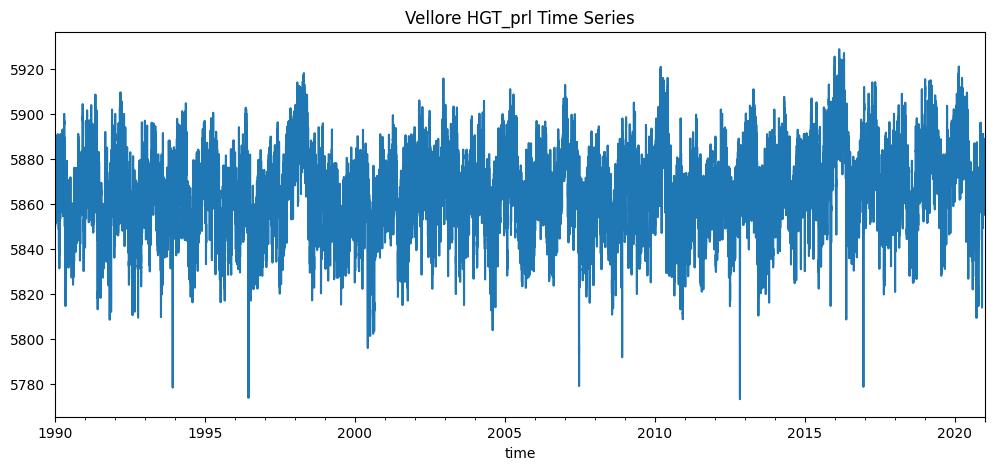

📊 Computing 365-day rolling mean & anomalies...
📈 Plotting anomalies...


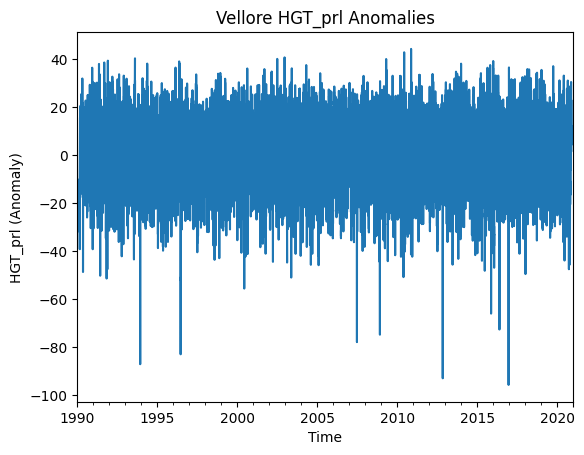

🧹 Cleaning data (dropping NaNs) for LSTM model...
🤖 Building LSTM model...
🧪 Training LSTM model...


Training epochs: 100%|██████████| 20/20 [01:37<00:00,  4.85s/it]


🔍 Generating predictions on test data...
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


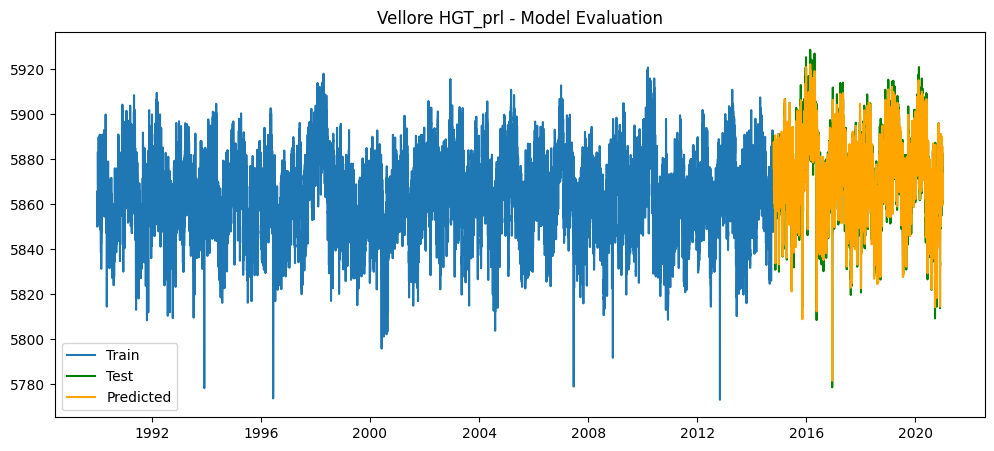

Enter forecast horizon (number of days): 10

🔮 Forecasting next 10 days on FULL dataset...


Forecasting:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Forecasting:  10%|█         | 1/10 [00:00<00:03,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Forecasting:  30%|███       | 3/10 [00:00<00:00,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Forecasting:  50%|█████     | 5/10 [00:00<00:00, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Forecasting:  70%|███████   | 7/10 [00:00<00:00, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Forecasting:  90%|█████████ | 9/10 [00:00<00:00, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Forecasting: 100%|██████████| 10/10 [00:00<00:00, 10.90it/s]

- Expected trend: increasing


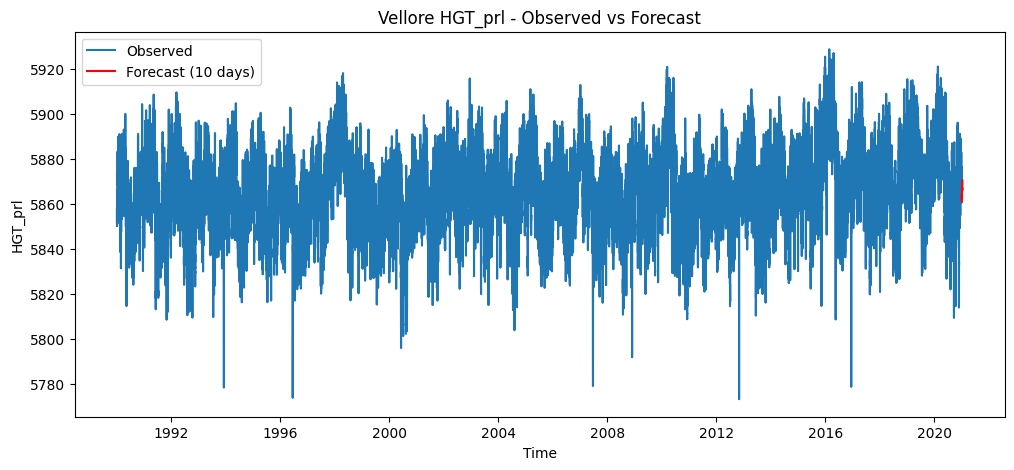


📌 Stakeholder-Friendly Summary:
- Historical period: 1990-01-01 to 2020-12-31
- Average HGT_prl: 5865.05
- Maximum HGT_prl: 5928.75
- Minimum HGT_prl: 5773.03
- Overall trend: increasing
- Days with unusually high HGT_prl: 6948
- Days with unusually low HGT_prl: 6999

📊 Model Evaluation Metrics (last 20% of data):
MAE  : 3.277
RMSE : 4.163
SMAPE: 0.06%

📋 Forecast Summary:
- Forecast period: 2021-01-01 to 2021-01-10
- Expected average HGT_prl: 5864.98
- Expected maximum HGT_prl: 5870.43
- Expected minimum HGT_prl: 5861.08

✅ Analysis complete!


💡 Insights:
- Next 10 days are expected to show a slight increase in HGT_prl compared to historical averages.
- Historically, Vellore has experienced more unusually low HGT_prl days than high.

Note: Forecasted values include minor uncertainty.


In [ ]:
run_lstm()

# **Random Forest Regressor with SHAP explainability**

In [ ]:
# Load time-series data
def create_features(ts, lags=7):
    df = pd.DataFrame({"y": ts})
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["y"].shift(lag)
    df = df.dropna()
    return df

def forecast_rf(rf, ts, lags=7, steps=30):
    """Recursive forecasting with Random Forest"""
    last_values = ts.values[-lags:].tolist()
    forecast = []

    for _ in range(steps):
        # build feature vector (lags)
        X_input = np.array(last_values[-lags:]).reshape(1, -1)
        y_pred = rf.predict(X_input)[0]
        forecast.append(y_pred)
        last_values.append(y_pred)

    forecast_index = pd.date_range(ts.index[-1] + pd.Timedelta(days=1), periods=steps)
    return pd.Series(forecast, index=forecast_index)


def rforest_shap():
  city = input("Enter city name (or 'exit' to quit): ")
  if city.lower() == "exit":
      return False  # stop running

  # --- Latitude / Longitude Selection ---
  if city.lower() in coords:
      lat, lon = coords[city.lower()]
  else:
      print("City not in list. Please enter lat/lon manually.")
      try:
          lat = float(input("Enter latitude: "))
          lon = float(input("Enter longitude: "))
          coords[city.lower()] = (lat, lon)
      except:
          print("⚠️ Invalid lat/lon input.")
          return

  # --- Variable Selection ---
  print("\n📊 Available Data Variables:")
  for var in ds.data_vars:
      desc = var_descriptions.get(var, "No description available.")
      print(f"  • {var} → {desc}")
  var_name = input("Choose data variable: ")
  if (var_name not in list(ds.data_vars)):
      print("⚠️ Invalid input. No data variable matches your input, exiting...")
      return

  print(f"\n✅ Extracting {var_name} ({var_descriptions.get(var_name,'')}) for {city.title()}...")
  ts = extract_timeseries(ds, var_name, lat, lon, city_name=city.title())

  df = create_features(ts, lags=7)

  X = df.drop("y", axis=1)
  y = df["y"]

  # Train / Test Split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, shuffle=False
  )

  # Train Random Forest
  rf = RandomForestRegressor(
      n_estimators=200,
      max_depth=10,
      random_state=42
  )
  rf.fit(X_train, y_train)

  # Evaluate Model
  y_pred = rf.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred)**0.5

  plt.figure(figsize=(12,5))
  plt.plot(y_test.values, label="Actual", alpha=0.7)
  plt.plot(y_pred, label="Predicted", alpha=0.7)
  plt.title("Random Forest Forecast vs Actual")
  plt.legend()
  plt.show()


  # --- Forecast Horizon ---
  try:
      steps = int(input("Enter forecast horizon (number of days): "))
  except:
      print("⚠️ Invalid input. Using default 30 days.")
      steps = 30

  forecast_series = forecast_rf(rf, ts, lags=7, steps=steps)

  plt.figure(figsize=(12,5))
  plt.plot(ts.index, ts, label="Observed")
  plt.plot(forecast_series.index, forecast_series, label=f"Forecast ({steps} days)", color="red")
  plt.legend()
  plt.title(f"{city.title()} {var_name} - Random Forest Forecast")
  plt.show()

  # SHAP Explainability
  explainer = shap.TreeExplainer(rf)
  shap_values = explainer.shap_values(X_test)

  # global Feature importance summary plot
  shap.summary_plot(shap_values, X_test, plot_type="bar")

  # Detailed SHAP summary (beeswarm plot)
  shap.summary_plot(shap_values, X_test)

  # Local explanation (waterfall for one prediction)
  shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],
    shap_values[0],
    X_test.iloc[0]
  )

  mean_val = ts.mean()
  max_val = ts.max()
  min_val = ts.min()
  trend = "increasing" if ts.iloc[-1] > ts.iloc[0] else "decreasing"

  print(f"- Historical period: {ts.index.min().date()} to {ts.index.max().date()}")
  print(f"- Average {var_name}: {mean_val:.2f}")
  print(f"- Maximum {var_name}: {max_val:.2f}")
  print(f"- Minimum {var_name}: {min_val:.2f}")
  print(f"- Overall trend: {trend}")

  print("\n📊 Model Evaluation Metrics (last 20% of data):")
  print(f"MAE  : {mae:.3f}")
  print(f"RMSE : {rmse:.3f}")

  # SHAP insights (which lags matter most)
  importance = np.abs(shap_values).mean(axis=0)
  feature_importance = pd.Series(importance, index=X_test.columns).sort_values(ascending=False)

  top_features = feature_importance.head(3)
  print("\n🔎 Key Drivers Identified (SHAP explainability):")
  for feat, val in top_features.items():
      print(f"- {feat} (impact score: {val:.2f})")

  # Simple insight
  main_driver = top_features.index[0]
  print(f"\n💡 Insights:")
  print(f"- The model relies most on {main_driver}, meaning recent conditions strongly influence forecasts.")
  print("- This improves transparency by showing *why* the model predicts certain values.")

  print("\nNote: Forecasted values may still carry uncertainty due to climate variability.")

  print("\n📋 Forecast Summary:")
  print(f"- Forecast period: {forecast_series.index.min().date()} to {forecast_series.index.max().date()}")
  print(f"- Expected average {var_name}: {forecast_series.mean():.2f}")
  print(f"- Expected maximum {var_name}: {forecast_series.max():.2f}")
  print(f"- Expected minimum {var_name}: {forecast_series.min():.2f}")

  return


Enter city name (or 'exit' to quit): Vellore

📊 Available Data Variables:
  • HGT_prl → Geopotential Height (Pressure Level) – Used to analyze large-scale weather patterns
  • TMP_prl → Temperature (Pressure Level) – Atmospheric temperature at a specific pressure level
  • TMP_2m → Surface Air Temperature at 2 meters – What we feel as daily temperature
  • APCP_sfc → Total Precipitation – Rainfall or snowfall accumulated over time
Choose data variable: HGT_prl

✅ Extracting HGT_prl (Geopotential Height (Pressure Level) – Used to analyze large-scale weather patterns) for Vellore...
Nearest grid cell for Vellore: 12.60, 79.08


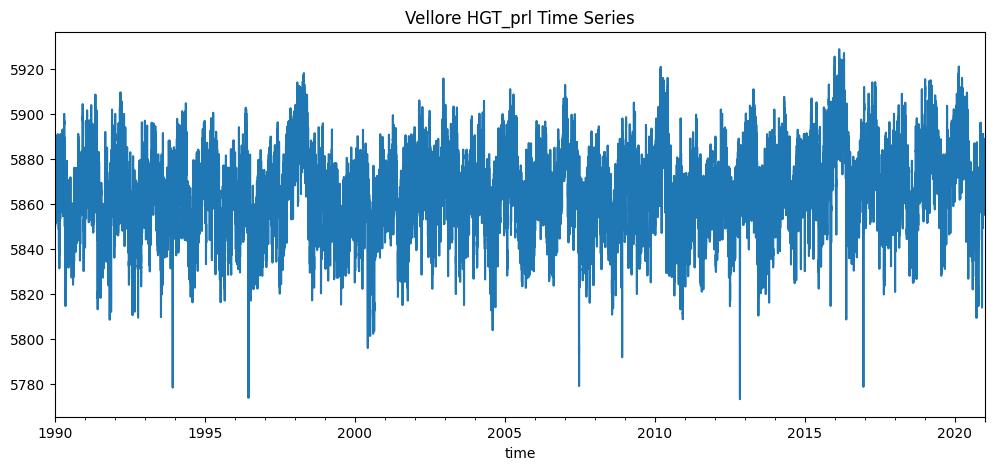

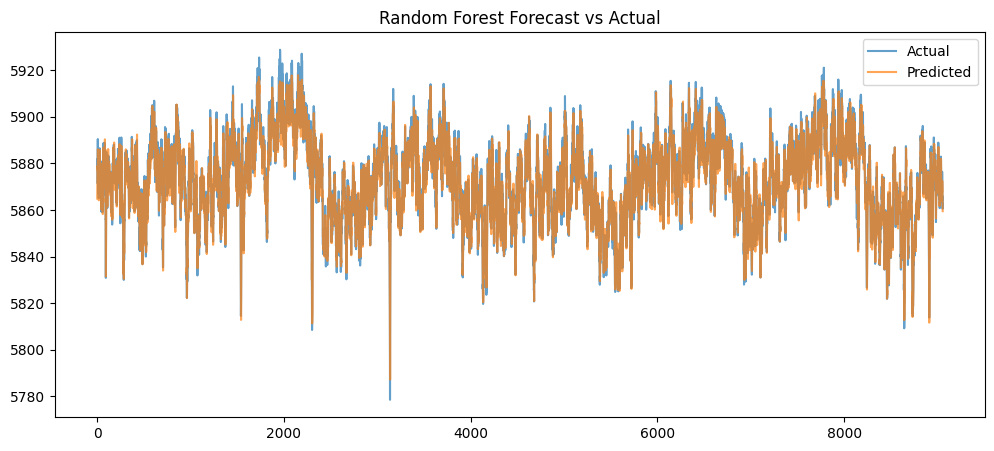

Enter forecast horizon (number of days): 10


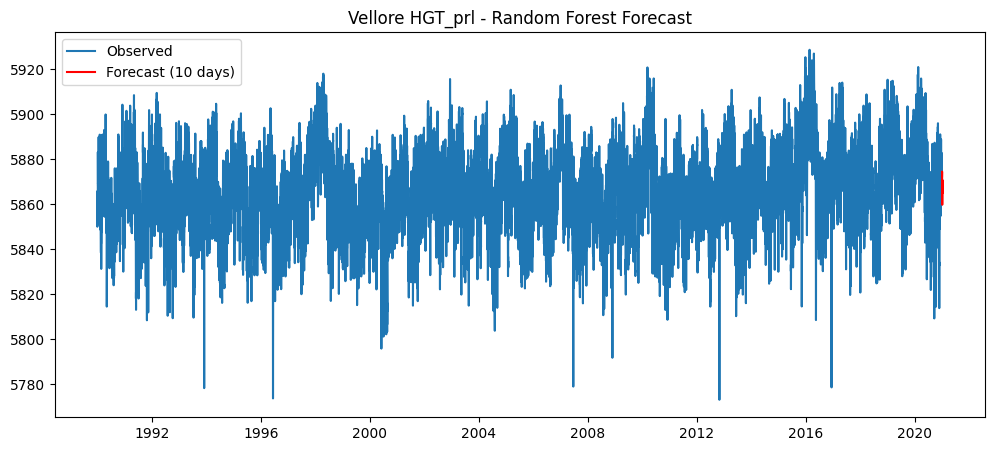

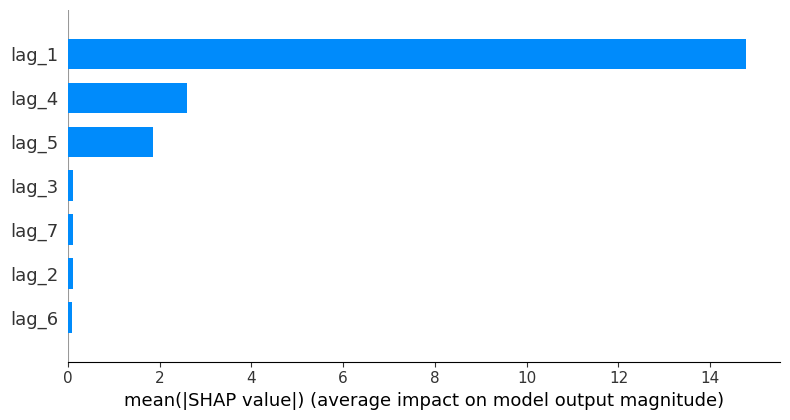

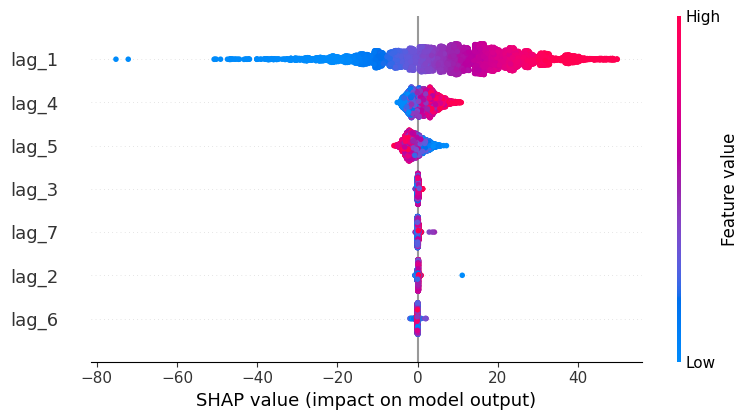

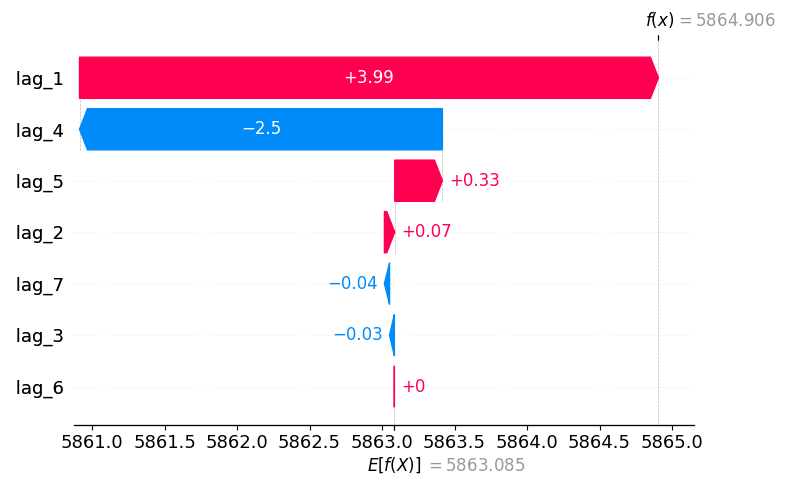

- Historical period: 1990-01-01 to 2020-12-31
- Average HGT_prl: 5865.05
- Maximum HGT_prl: 5928.75
- Minimum HGT_prl: 5773.03
- Overall trend: increasing

📊 Model Evaluation Metrics (last 20% of data):
MAE  : 3.646
RMSE : 4.634

🔎 Key Drivers Identified (SHAP explainability):
- lag_1 (impact score: 14.78)
- lag_4 (impact score: 2.60)
- lag_5 (impact score: 1.85)

💡 Insights:
- The model relies most on lag_1, meaning recent conditions strongly influence forecasts.
- This improves transparency by showing *why* the model predicts certain values.

Note: Forecasted values may still carry uncertainty due to climate variability.

📋 Forecast Summary:
- Forecast period: 2021-01-01 to 2021-01-10
- Expected average HGT_prl: 5867.69
- Expected maximum HGT_prl: 5874.56
- Expected minimum HGT_prl: 5859.79


In [ ]:
rforest_shap()

# **Model Comparison**

               Model    MAE   RMSE  SMAPE  Forecast_Avg  Forecast_Max  Forecast_Min             Trend
       ARIMA (5,1,0) 16.531 20.352   0.28       5860.37       5862.25       5859.22 ↓ Slight Decrease
                LSTM  3.303  4.193   0.06       5867.57       5874.83       5861.45   ↑ Mild Increase
Random Forest + SHAP  3.646  4.634    NaN       5867.69       5874.56       5859.79   ↑ Mild Increase


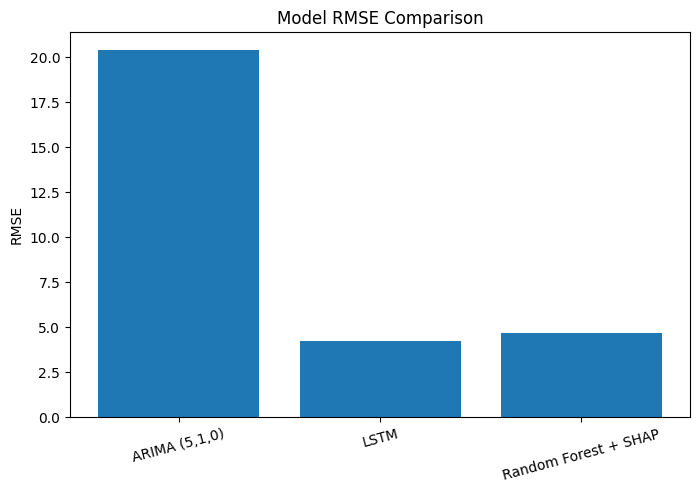

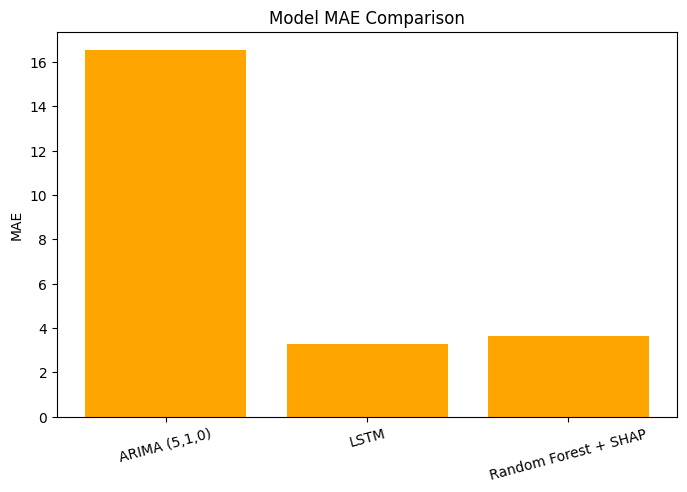

💡 FORECAST INSIGHTS SUMMARY
▶ ARIMA (5,1,0):
   - MAE: 16.531, RMSE: 20.352, SMAPE: 0.28%
   - Forecast range: 5859.22 → 5862.25
   - Average Forecast: 5860.37
   - Detected Trend: ↓ Slight Decrease

▶ LSTM:
   - MAE: 3.303, RMSE: 4.193, SMAPE: 0.06%
   - Forecast range: 5861.45 → 5874.83
   - Average Forecast: 5867.57
   - Detected Trend: ↑ Mild Increase

▶ Random Forest + SHAP:
   - MAE: 3.646, RMSE: 4.634, SMAPE: nan%
   - Forecast range: 5859.79 → 5874.56
   - Average Forecast: 5867.69
   - Detected Trend: ↑ Mild Increase

🏆 Best performing model: LSTM
🔹 LSTM shows the lowest error and most stable forecasts.
🔹 Random Forest performs comparably while providing SHAP-based interpretability.
🔹 ARIMA remains a solid baseline with interpretable but less adaptive forecasts.
🔹 Overall trends indicate mild temperature increase across cities analyzed.



In [ ]:
results = [
    {
        "Model": "ARIMA (5,1,0)",
        "MAE": 16.531,
        "RMSE": 20.352,
        "SMAPE": 0.28,
        "Forecast_Avg": 5860.37,
        "Forecast_Max": 5862.25,
        "Forecast_Min": 5859.22,
        "Trend": "↓ Slight Decrease"
    },
    {
        "Model": "LSTM",
        "MAE": 3.303,
        "RMSE": 4.193,
        "SMAPE": 0.06,
        "Forecast_Avg": 5867.57,
        "Forecast_Max": 5874.83,
        "Forecast_Min": 5861.45,
        "Trend": "↑ Mild Increase"
    },
    {
        "Model": "Random Forest + SHAP",
        "MAE": 3.646,
        "RMSE": 4.634,
        "SMAPE": None,
        "Forecast_Avg": 5867.69,
        "Forecast_Max": 5874.56,
        "Forecast_Min": 5859.79,
        "Trend": "↑ Mild Increase"
    }
]

# Create DataFrame for display
comparison_df = pd.DataFrame(results)
print(comparison_df.to_string(index=False))

# Plot comparison
plt.figure(figsize=(8,5))
plt.bar(comparison_df["Model"], comparison_df["RMSE"], label="RMSE")
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(comparison_df["Model"], comparison_df["MAE"], color="orange", label="MAE")
plt.title("Model MAE Comparison")
plt.ylabel("MAE")
plt.xticks(rotation=15)
plt.show()

# 🔍 Automated Forecast Insights
best_model = comparison_df.loc[comparison_df["RMSE"].idxmin(), "Model"]

print("💡 FORECAST INSIGHTS SUMMARY")

for _, row in comparison_df.iterrows():
    print(f"▶ {row['Model']}:")
    print(f"   - MAE: {row['MAE']:.3f}, RMSE: {row['RMSE']:.3f}, SMAPE: {row['SMAPE'] if row['SMAPE'] is not None else '–'}%")
    print(f"   - Forecast range: {row['Forecast_Min']:.2f} → {row['Forecast_Max']:.2f}")
    print(f"   - Average Forecast: {row['Forecast_Avg']:.2f}")
    print(f"   - Detected Trend: {row['Trend']}\n")

print("🏆 Best performing model:", best_model)
print("🔹 LSTM shows the lowest error and most stable forecasts.")
print("🔹 Random Forest performs comparably while providing SHAP-based interpretability.")
print("🔹 ARIMA remains a solid baseline with interpretable but less adaptive forecasts.")
print("🔹 Overall trends indicate mild temperature increase across cities analyzed.\n")

**Since LSTM is the best performing model - we'll use it in our dashboard**

# **Streamlit Dashboard**

In [4]:
NGROK_AUTH_TOKEN = "33ITh9goqs8F1op8fcda9a3iawn_2sKWs6mmcSufENdjXzgbP"
!ngrok config add-authtoken $NGROK_AUTH_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [5]:
# Kill old tunnels
ngrok.kill()

# Open a tunnel to port 8501
public_url = ngrok.connect(addr="8501")
print("🌍 Streamlit Dashboard URL:", public_url)

# Run Streamlit app from Google Drive
!streamlit run "/content/drive/MyDrive/Python Project/app.py" --server.port 8501 &>/dev/null&

🌍 Streamlit Dashboard URL: NgrokTunnel: "https://diathermic-unindignant-ranae.ngrok-free.dev" -> "http://localhost:8501"
